## 1. Preparing our dataset
<p><em>These recommendations are so on point! How does this playlist know me so well?</em></p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_449/img/iphone_music.jpg" alt="Project Image Record" width="600px"></p>
<p>Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.</p>
<p>For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, such as decision trees and logistic regression.</p>
<p>To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as <code>danceability</code> and <code>acousticness</code> on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.</p>
<p>Let's start by creating two pandas <code>DataFrames</code> out of these files that we can merge so we have features and labels (often also referred to as <code>X</code> and <code>y</code>) for the classification later on.</p>

# EDA

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import time
import random

random.seed(100)

In [2]:
# Read in track metadata with genre labels
tracks = pd.read_csv("F:\sanket\Important\studies\Classify-Song-Genres-from-Audio-Data-master\Classify-Song-Genres-from-Audio-Data-master/fma-rock-vs-hiphop.csv")



In [3]:
tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [4]:
# Read in track metrics with the features
echonest_metrics = pd.read_json("F:\sanket\Important\studies\Classify-Song-Genres-from-Audio-Data-master\Classify-Song-Genres-from-Audio-Data-master/echonest-metrics.json", precise_float=True)
echonest_metrics.head()


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
10,145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,120.790,0.650452
100,341,0.977282,0.468808,0.134975,0.687700,0.105381,0.073124,119.646,0.430707
1000,3457,0.081256,0.897197,0.367886,0.104474,0.085845,0.041271,100.744,0.749293


In [5]:
# Merge the relevant columns of tracks and echonest_metrics
echo_tracks = pd.merge(echonest_metrics, tracks[["track_id", "genre_top"]], on="track_id")
echo_tracks.head()


,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,341,0.977282,0.468808,0.134975,0.687700,0.105381,0.073124,119.646,0.430707,Rock
3,46204,0.953349,0.498525,0.552503,0.924391,0.684914,0.028885,78.958,0.430448,Rock
4,46205,0.613229,0.500320,0.487992,0.936811,0.637750,0.030327,112.667,0.824749,Rock


In [6]:
# Inspect the resultant dataframe
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
track_id            4802 non-null int64
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


In [7]:
display(echo_tracks["genre_top"].value_counts())

Rock       3892
Hip-Hop     910
Name: genre_top, dtype: int64

##  Pairwise relationships between continuous variables
<p>We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:</p>
<ul>
<li>To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).</li>
<li>When our datasets are very large, using fewer features can drastically speed up our computation time.</li>
</ul>
<p>To get a sense of whether there are any strongly correlated features in our data, we will use built-in functions in the <code>pandas</code> package.</p>

In [8]:
# Create a correlation matrix
corr_metrics = echo_tracks.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1,-0.372282,0.0494541,0.140703,-0.275623,0.0482307,-0.0269951,-0.0253918,0.0100698
acousticness,-0.372282,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.0138406
danceability,0.0494541,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.0386027
instrumentalness,-0.275623,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.219967
liveness,0.0482307,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,-0.0450931
speechiness,-0.0269951,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,0.149894
tempo,-0.0253918,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,0.0522212
valence,0.0100698,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,1


In [9]:
echo_tracks.drop(["track_id"], axis=1).describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
count,4.802000e+03,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000,4802.000000
mean,4.870600e-01,0.436556,0.625126,0.604096,0.187997,0.104877,126.687944,0.453413
std,3.681396e-01,0.183502,0.244051,0.376487,0.150562,0.145934,34.002473,0.266632
min,9.491000e-07,0.051307,0.000279,0.000000,0.025297,0.023234,29.093000,0.014392
25%,8.351236e-02,0.296047,0.450757,0.164972,0.104052,0.036897,98.000750,0.224617
50%,5.156888e-01,0.419447,0.648374,0.808752,0.123080,0.049594,124.625500,0.446240
75%,8.555765e-01,0.565339,0.837016,0.915472,0.215151,0.088290,151.450000,0.666914
max,9.957965e-01,0.961871,0.999768,0.993134,0.971392,0.966177,250.059000,0.983649


In [10]:
# Define our features 
features = echo_tracks.drop(["genre_top","track_id"], axis=1)
features.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,0.977282,0.468808,0.134975,0.687700,0.105381,0.073124,119.646,0.430707
3,0.953349,0.498525,0.552503,0.924391,0.684914,0.028885,78.958,0.430448
4,0.613229,0.500320,0.487992,0.936811,0.637750,0.030327,112.667,0.824749


In [11]:
# Define our labels
labels = echo_tracks["genre_top"]
labels.head()

0    Hip-Hop
1    Hip-Hop
2       Rock
3       Rock
4       Rock
Name: genre_top, dtype: object

In [12]:
# Scale the features and set the values to a new variable
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
features = sc_X.fit_transform(features)
pd.DataFrame(features).head()


,0,1,2,3,4,5,6,7
0,-0.191210,1.304420,0.038316,-1.576494,-0.068755,0.373034,1.153979,0.462287
1,-0.306036,0.501886,0.788176,-1.599809,-0.545463,2.446155,0.007914,-0.690811
2,1.331757,0.175777,-2.008607,0.222085,-0.548779,-0.217608,-0.207122,-0.085167
3,1.266742,0.337737,-0.297606,0.850834,3.300761,-0.520786,-1.403866,-0.086139
4,0.342755,0.347522,-0.561966,0.883828,2.987475,-0.510901,-0.412394,1.392836


In [13]:
Cat=echo_tracks.drop(["track_id"], axis=1)
Cat.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,0.977282,0.468808,0.134975,0.687700,0.105381,0.073124,119.646,0.430707,Rock
3,0.953349,0.498525,0.552503,0.924391,0.684914,0.028885,78.958,0.430448,Rock
4,0.613229,0.500320,0.487992,0.936811,0.637750,0.030327,112.667,0.824749,Rock


In [14]:
Cat.shape

(4802, 9)

In [15]:
# Encoding categorical data
# Encoding the Independent Variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X = LabelEncoder()
Cat['genre_top'] = labelencoder_X.fit_transform(Cat['genre_top'])
Cat.head()



,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,0
1,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,0
2,0.977282,0.468808,0.134975,0.687700,0.105381,0.073124,119.646,0.430707,1
3,0.953349,0.498525,0.552503,0.924391,0.684914,0.028885,78.958,0.430448,1
4,0.613229,0.500320,0.487992,0.936811,0.637750,0.030327,112.667,0.824749,1


In [16]:
pd.DataFrame(Cat['genre_top']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 1 columns):
genre_top    4802 non-null int32
dtypes: int32(1)
memory usage: 56.3 KB


In [17]:
## Correlation Matrix
sns.set(style="white")

# Compute the correlation matrix
corr = Cat.corr()

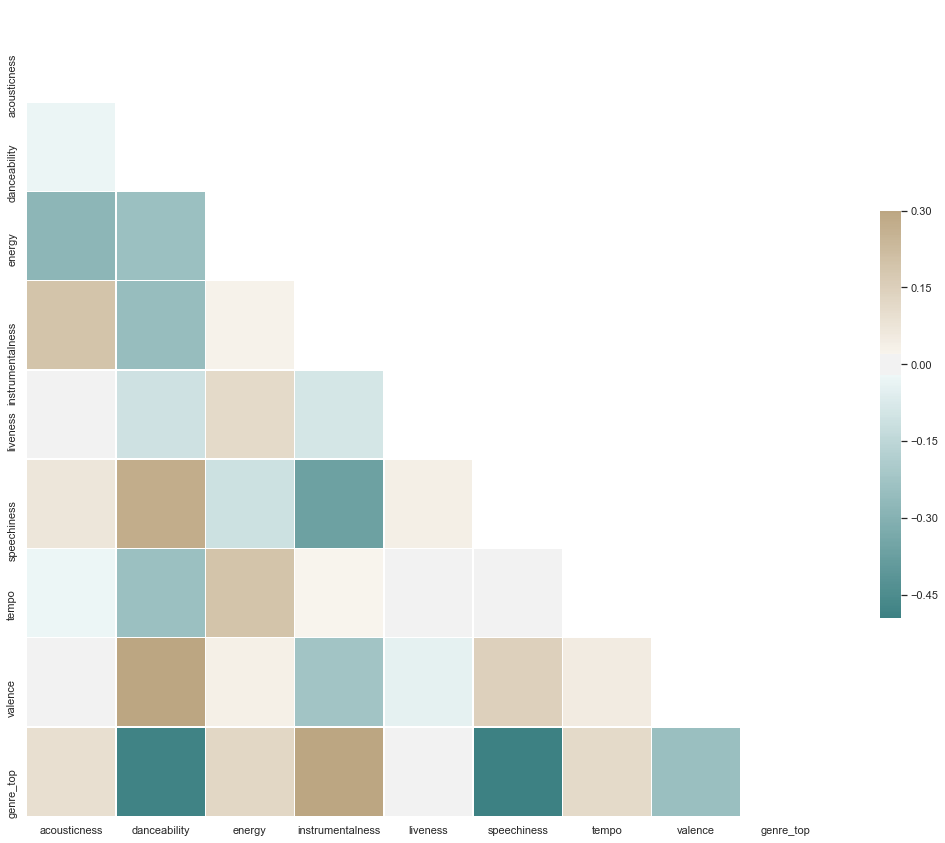

In [22]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(555, 55, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Feature Selection 

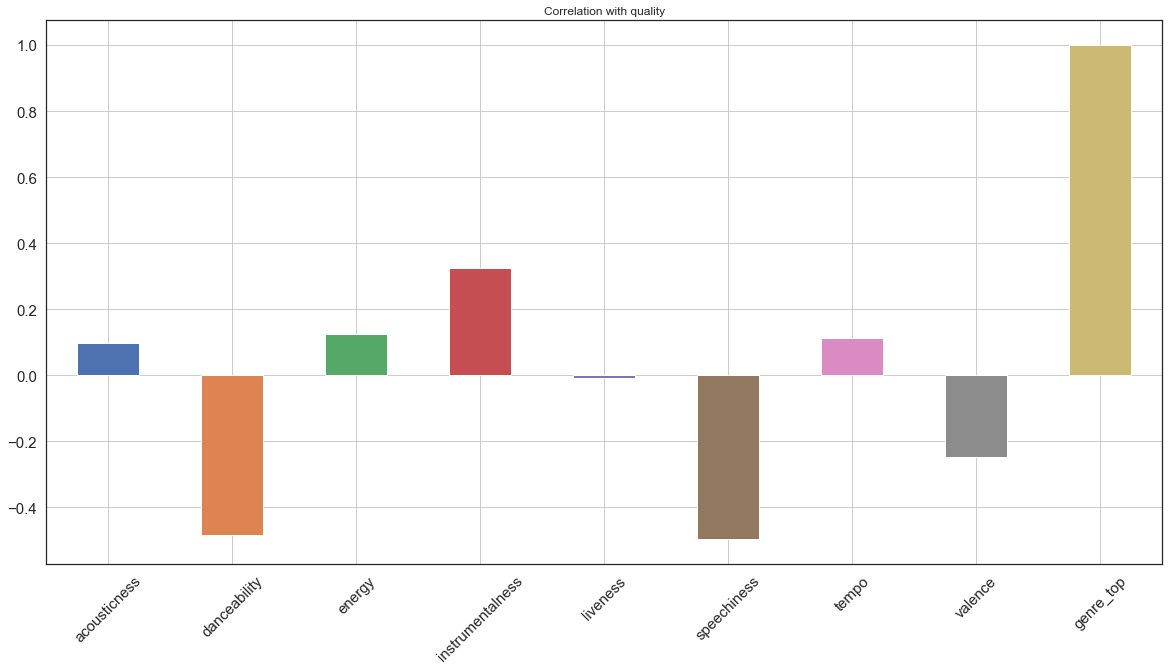

In [23]:
#Correlation with Quality with respect to attributes
Cat.corrwith(Cat.genre_top).plot.bar(
        figsize = (20, 10), title = "Correlation with quality", fontsize = 15,
        rot = 45, grid = True)

In [24]:
#Assigning and dividing the dataset
X = Cat.drop('genre_top',axis=1)
y=Cat['genre_top']

In [25]:
Cat.shape

(4802, 9)

In [26]:
features_label = Cat.columns[:9]

In [27]:
#Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 0)
classifier.fit(X, y)
importances = classifier.feature_importances_
indices = np. argsort(importances)[::-1]
for i in range(X.shape[1]):
    print ("%2d) %-*s %f" % (i + 1, 30, features_label[i],importances[indices[i]]))

 1) acousticness                   0.291268
 2) danceability                   0.195556
 3) energy                         0.109283
 4) instrumentalness               0.106060
 5) liveness                       0.087014
 6) speechiness                    0.082872
 7) tempo                          0.079861
 8) valence                        0.048086


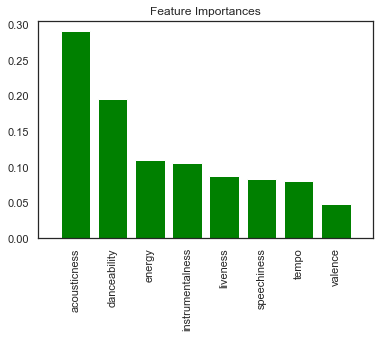

In [28]:
plt.title('Feature Importances')
plt.bar(range(X.shape[1]),importances[indices], color="green", align="center")
plt.xticks(range(X.shape[1]),features_label, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

##  Normalizing the feature data and Model Training
<p>As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called <strong>principal component analysis (PCA)</strong>. </p>
<p>It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes. </p>
<p>However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our data. There are a few methods to do this, but a common way is through <em>standardization</em>, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score).</p>

In [29]:

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 5)

In [30]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train2 = pd.DataFrame(sc.fit_transform(X_train))
X_test2 = pd.DataFrame(sc.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

In [31]:
#Using Principal Dimensional Reduction
from sklearn.decomposition import PCA
pca = PCA(n_components = None )
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print(pd.DataFrame(explained_variance))

          0
0  0.243518
1  0.179209
2  0.138873
3  0.127786
4  0.111866
5  0.082544
6  0.069918
7  0.046286


Text(0.5, 0, 'Principal Component #')

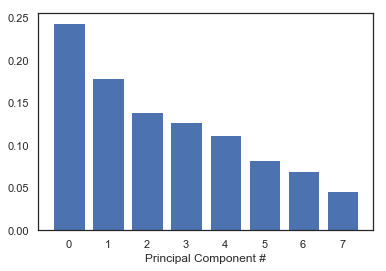

In [32]:
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(8), explained_variance)
ax.set_xlabel('Principal Component #')

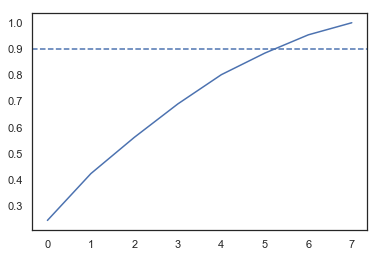

In [33]:
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(explained_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(range(8), cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(features)
pca_projection = pca.transform(features)

In [34]:
#### Model Building ####

### Comparing Models

## Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, penalty = 'l1')
classifier.fit(X_train, y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

results = pd.DataFrame([['Logistic Regression', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(results)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.880333   0.888623  0.971204   0.92808


C:\Users\Sanket\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [35]:
## Randomforest
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 0, n_estimators = 100,
                                    criterion = 'entropy')
classifier.fit(X_train, y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['Random Forest (n=100)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)
print(results)

                   Model  Accuracy  Precision    Recall  F1 Score
0    Logistic Regression  0.880333   0.888623  0.971204  0.928080
1  Random Forest (n=100)  0.898023   0.910099  0.967277  0.937817


In [36]:
## Decision Tree
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['Decision Tree ', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)
print(results)

                   Model  Accuracy  Precision    Recall  F1 Score
0    Logistic Regression  0.880333   0.888623  0.971204  0.928080
1  Random Forest (n=100)  0.898023   0.910099  0.967277  0.937817
2         Decision Tree   0.849116   0.897304  0.914921  0.906027


In [37]:
## SVM (Linear)
from sklearn.svm import SVC
classifier = SVC(random_state = 0, kernel = 'linear')
classifier.fit(X_train, y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['SVM (Linear)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)
print(results)

                   Model  Accuracy  Precision    Recall  F1 Score
0    Logistic Regression  0.880333   0.888623  0.971204  0.928080
1  Random Forest (n=100)  0.898023   0.910099  0.967277  0.937817
2         Decision Tree   0.849116   0.897304  0.914921  0.906027
3           SVM (Linear)  0.881374   0.889688  0.971204  0.928661


In [38]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
# Predicting Test Set
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['KNN', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)
print(results)


                   Model  Accuracy  Precision    Recall  F1 Score
0    Logistic Regression  0.880333   0.888623  0.971204  0.928080
1  Random Forest (n=100)  0.898023   0.910099  0.967277  0.937817
2         Decision Tree   0.849116   0.897304  0.914921  0.906027
3           SVM (Linear)  0.881374   0.889688  0.971204  0.928661
4                    KNN  0.886576   0.899878  0.964660  0.931143


In [39]:
## SVM (rbf)
from sklearn.svm import SVC
classifier = SVC(random_state = 0, kernel = 'rbf')
classifier.fit(X_train, y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['SVM (RBF)', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)
print(results)

                   Model  Accuracy  Precision    Recall  F1 Score
0    Logistic Regression  0.880333   0.888623  0.971204  0.928080
1  Random Forest (n=100)  0.898023   0.910099  0.967277  0.937817
2         Decision Tree   0.849116   0.897304  0.914921  0.906027
3           SVM (Linear)  0.881374   0.889688  0.971204  0.928661
4                    KNN  0.886576   0.899878  0.964660  0.931143
5              SVM (RBF)  0.906348   0.909976  0.979058  0.943253


So the SVM kernal is the highest accuracy model

In [40]:
## K-fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X= X_train, y = y_train,
                             cv = 10)
print("SVM Classifier Accuracy: %0.2f (+/- %0.2f)"  % (accuracies.mean(), accuracies.std() * 2))

C:\Users\Sanket\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Sanket\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Sanket\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Sanket\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

SVM Classifier Accuracy: 0.92 (+/- 0.03)


In [41]:

parameters = {"C": [0.1,0.3,1,3,10,30],
              
              'gamma': [.001,.01,.1,.3,1],
             }

     



from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(  estimator = classifier, # Make sure classifier points to the SVM RBF model
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 5,
                           n_jobs = -1
                          ,verbose=1)

t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   23.7s finished


Took 24.25 seconds


(0.9213746420203072, {'C': 1, 'gamma': 0.1})

In [42]:
rf_best_accuracy, rf_best_parameters

(0.9213746420203072, {'C': 1, 'gamma': 0.1})

In [43]:
# Predicting Test Set
y_pred = grid_search.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results = pd.DataFrame([['SVM RBF Grid results', acc, prec, rec, f1]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

results = results.append(model_results, ignore_index = True)
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.880333,0.888623,0.971204,0.928080
1,Random Forest (n=100),0.898023,0.910099,0.967277,0.937817
2,Decision Tree,0.849116,0.897304,0.914921,0.906027
3,SVM (Linear),0.881374,0.889688,0.971204,0.928661
4,KNN,0.886576,0.899878,0.964660,0.931143
5,SVM (RBF),0.906348,0.909976,0.979058,0.943253
6,SVM RBF Grid results,0.904266,0.908759,0.977749,0.941992


In [44]:
# Create the classification report for both models
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.62      0.73       197
           1       0.91      0.98      0.94       764

   micro avg       0.90      0.90      0.90       961
   macro avg       0.89      0.80      0.83       961
weighted avg       0.90      0.90      0.90       961



In [45]:
import matplotlib.pyplot as plt
import itertools

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[122  75]
 [ 17 747]]


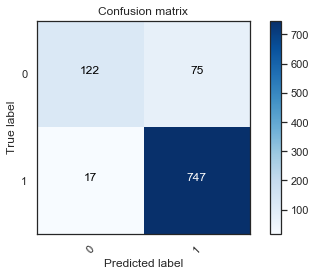

In [46]:
# Making the Confusion Matrix 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(cm,classes=[0,1])
sns.set(rc={'figure.figsize':(6,6)})
plt.show()
